# Sistema de detecção e reconhecimento de faces humanas

Nosso sistema deve ser capaz de detectar a região que representa a fa e identificar a quem a face pertenceão

Primeiramente vamos trabalhar com um virtualenv.
.

In [2]:
# Descomente se for a 1a vez rodando
# !virtualenv facial-reco
# !facial-reco\Scripts\activate
# !pip3 install -r requirements.txt

created virtual environment CPython3.9.13.final.0-64 in 3610ms
  creator Venv(dest=C:\Users\orlan\OneDrive\Documentos\UFF\DIO\ML\Criando um Sistema de Reconhecimento Facial do Zero\facial-reco, clear=False, no_vcs_ignore=False, global=False, describe=CPython3Windows)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=C:\Users\orlan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\Local\pypa\virtualenv)
    added seed packages: pip==23.2.1, setuptools==68.0.0, wheel==0.41.0
  activators BashActivator,BatchActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [2]:
import imutils
import numpy as np
import cv2
from base64 import b64decode
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout
import scipy

400 299


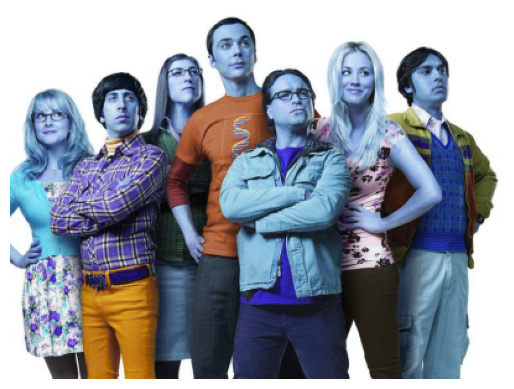

In [4]:
image_path = "single_prediction/elenco.jpg"

image = cv2.imread(image_path)

# redimensiona para ter uma largura máxima de 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)

# Exibir a imagem usando plt.imshow
plt.imshow(image)
plt.axis('off')  # Desabilitar eixos
plt.show()       # Mostrar a imagem

O detector de face em Deep Learning do OpenCV é baseado na estrutura Single Shot Detector (SSD) com uma rede base ResNet. A rede é definida e treinada usando o Caffe Deep Learning framework.

Baixe o modelo de detecção de rosto pré-treinado, composto por dois arquivos:

A definição de rede (deploy.prototxt)
Os pesos aprendidos (res10_300x300_ssd_iter_140000.caffemodel)

In [20]:
# Descomentar se for a 1a vez rodando
# # URLs para os arquivos
# deploy_url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"
# model_url = "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel"

# # Nomes dos arquivos locais
# deploy_filename = "deploy.prototxt"
# model_filename = "res10_300x300_ssd_iter_140000.caffemodel"

# # Fazer o download dos arquivos
# urllib.request.urlretrieve(deploy_url, deploy_filename)
# urllib.request.urlretrieve(model_url, model_filename)

# print("Arquivos baixados com sucesso!")

Arquivos baixados com sucesso!


Carregar o modelo de rede de detecção facial pré-treinado do disco




In [5]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)


[INFO] loading model...


Use a função dnn.blobFromImage para construir um blob de entrada redimensionando a imagem para 300x300 pixels fixos e normalizando-a


In [15]:
pre_proc_path = "pre-proc-imgs"

def detect_faces(img_path, category):
    destination_folder = f"training-images/{category}"
    image =  cv2.imread(img_path)
        
    # redimensiona para ter uma largura máxima de 400 pixels
    image = imutils.resize(image, width=400)
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    
    print(f"[INFO] computing object detections on {img_path}...")
    net.setInput(blob)
    try:
        detections = net.forward()
    except:
        print("Nenhuma face encontrada")
        return
        
    for i in range(0, detections.shape[2]):
        # extrair a probabilidade associada à previsão
        confidence = detections[0, 0, i, 2]
    
        # filtra detecções fracas garantindo que a "confiança" seja
        # maior que o limite mínimo de confiança
        if confidence > 0.5: #Nossa detecção deve ter no mínimo 50% de certeza
            # calcula as coordenadas (x, y) da caixa delimitadora do objeto
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
           
            # Converter a região de face em escala de cinza para uma imagem BGR
            query_face = image[startY:endY, startX:endX]
        
            # desenha a caixa delimitadora da face
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
    
            # Salvar a região da face na pasta de destino
            if not os.path.exists(destination_folder):
                os.makedirs(destination_folder)
            
            # Define o nome de arquivo para a face baseado no índice do loop
            face_filename = f"{destination_folder}/{os.path.splitext(os.path.basename(img_path))[0]}_face_{i}.jpg"

            try:
                # Salva a região da face na pasta de destino
                cv2.imwrite(face_filename, query_face)
            except:
                print(f"Error on image {face_filename}")
                print(f"Start coordinates: ({startX}, {startY}), End coordinates: ({endX}, {endY})")
                print(f"Image shape: {image.shape}")
            

for category_name in os.listdir(pre_proc_path):
    folder_path = os.path.join(pre_proc_path, category_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            detect_faces(file_path, category_name)



[INFO] computing object detections on pre-proc-imgs\amy\0 (1).jpg...
[INFO] computing object detections on pre-proc-imgs\amy\0 (10).jpg...
[INFO] computing object detections on pre-proc-imgs\amy\0 (11).jpg...
[INFO] computing object detections on pre-proc-imgs\amy\0 (12).jpg...
[INFO] computing object detections on pre-proc-imgs\amy\0 (13).jpg...
[INFO] computing object detections on pre-proc-imgs\amy\0 (14).jpg...
[INFO] computing object detections on pre-proc-imgs\amy\0 (15).jpg...
[INFO] computing object detections on pre-proc-imgs\amy\0 (16).jpg...
[INFO] computing object detections on pre-proc-imgs\amy\0 (17).jpg...
[INFO] computing object detections on pre-proc-imgs\amy\0 (18).jpg...
[INFO] computing object detections on pre-proc-imgs\amy\0 (19).jpg...
[INFO] computing object detections on pre-proc-imgs\amy\0 (20).jpg...
[INFO] computing object detections on pre-proc-imgs\amy\0 (21).jpg...
[INFO] computing object detections on pre-proc-imgs\amy\0 (22).jpg...
[INFO] computing obje

O nosso modelo já é capaz de detectar as faces das imagens, agora vamos para a parte de classificação. 
Importando o modelo MobileNet que foi previamente treinado no ImageNet e descartando a última camada de neurônios:

In [16]:
from keras.applications import MobileNetV2

# Definindo a quantidade de classes
num_classes = 7

# Carregando o modelo MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adicionando camadas personalizadas ao final do modelo
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Criando o modelo final
class_model = Model(inputs=base_model.input, outputs=predictions)

Como temos poucas imagens por categoria, vou realizar um data_augment nas imagens que temos e treinar o modelo com as imagens e suas categorias.

In [17]:
# Definindo quais camadas serão treinadas
for layer in class_model.layers[:130]:
    layer.trainable = False
for layer in class_model.layers[130:]:
    layer.trainable = True

# Definindo o tamanho do batch
batch_size = 32

# Configurando o ImageDataGenerator para treinamento e teste
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.4,
    zoom_range=0.4,
    height_shift_range=0.3,
    width_shift_range=0.3,
    rotation_range=50,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
    'training-images', # Pasta raiz das imagens das classes
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=True
)

test_set = test_datagen.flow_from_directory(
    'test-images', # Pasta raiz das imagens de teste das classes
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 324 images belonging to 7 classes.
Found 52 images belonging to 7 classes.


In [19]:
###Treinamento

#Definindo os parâmetros de compilação da rede:

class_model.compile(optimizer=Adam(learning_rate = 0.0001),loss='categorical_crossentropy',metrics=['categorical_accuracy'])

#Fazendo o treinamento da rede:

history = class_model.fit(x=training_set,
                   steps_per_epoch=324/batch_size,
                   epochs=50,
                   validation_data = test_set,
                   validation_steps = 52/batch_size)

Epoch 1/50
10/10 [==============================] - 8s 560ms/step - loss: 0.8792 - categorical_accuracy: 0.6790 - val_loss: 4.5333 - val_categorical_accuracy: 0.1538
Epoch 2/50
10/10 [==============================] - 5s 496ms/step - loss: 0.8967 - categorical_accuracy: 0.6698 - val_loss: 4.1218 - val_categorical_accuracy: 0.1923
Epoch 3/50
10/10 [==============================] - 5s 523ms/step - loss: 0.9167 - categorical_accuracy: 0.6728 - val_loss: 4.3841 - val_categorical_accuracy: 0.0769
Epoch 4/50
10/10 [==============================] - 5s 517ms/step - loss: 0.7800 - categorical_accuracy: 0.7099 - val_loss: 4.3698 - val_categorical_accuracy: 0.0769
Epoch 5/50
10/10 [==============================] - 5s 522ms/step - loss: 0.8760 - categorical_accuracy: 0.7037 - val_loss: 4.2353 - val_categorical_accuracy: 0.1154
Epoch 6/50
10/10 [==============================] - 5s 509ms/step - loss: 0.8949 - categorical_accuracy: 0.6914 - val_loss: 4.6843 - val_categorical_accuracy: 0.0769
Epoc

In [20]:
# Salvando o modelo para utilização futura:

class_model.save('tbbt_mobilenet.keras')

In [27]:
# Diretório com as imagens de teste
test_dir = 'single_prediction/'

# Listar os arquivos na pasta single_prediction
files = os.listdir('single_prediction')
print(files)

# Lista de categorias
categories = ['amy', 'bernadette', 'howard', 'leonard', 'penny', 'raj', 'sheldon']

['amy.jpg', 'bernadette.jpg', 'howard.jpg', 'leonard.jpg', 'penny.jpg', 'raj.jpg', 'sheldon.jpg']


In [28]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input

for file_name in files:
     # Carregar a imagem
    img_path = os.path.join(test_dir, file_name)
    test_image = load_img(img_path, target_size=(224, 224))
    
    # Pré-processamento da imagem para a previsão
    test_image = img_to_array(test_image)
    test_image = preprocess_input(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    
    # Fazer a previsão
    result = class_model.predict(test_image)
    
    # Imprimir o resultado para cada categoria
    print(f"Resultado para a imagem '{file_name}':")
    for i, category in enumerate(categories):
        percentage = result[0][i] * 100
        print(f"{category}: {percentage:.2f}%")
    
    # Encontrar a categoria com maior probabilidade
    predicted_category = categories[np.argmax(result)]
    print(f"Categoria prevista: {predicted_category}\n")

1/1 [==============================] - 0s 29ms/step
Resultado para a imagem 'amy.jpg':
amy: 47.57%
bernadette: 36.24%
howard: 0.03%
leonard: 0.22%
penny: 0.41%
raj: 1.22%
sheldon: 14.31%
Categoria prevista: amy

1/1 [==============================] - 0s 26ms/step
Resultado para a imagem 'bernadette.jpg':
amy: 26.89%
bernadette: 3.70%
howard: 0.38%
leonard: 2.71%
penny: 0.34%
raj: 34.14%
sheldon: 31.84%
Categoria prevista: raj

1/1 [==============================] - 0s 26ms/step
Resultado para a imagem 'howard.jpg':
amy: 5.61%
bernadette: 21.08%
howard: 6.08%
leonard: 0.03%
penny: 22.11%
raj: 26.49%
sheldon: 18.61%
Categoria prevista: raj

1/1 [==============================] - 0s 27ms/step
Resultado para a imagem 'leonard.jpg':
amy: 53.26%
bernadette: 4.48%
howard: 0.98%
leonard: 0.30%
penny: 1.78%
raj: 37.85%
sheldon: 1.36%
Categoria prevista: amy

1/1 [==============================] - 0s 26ms/step
Resultado para a imagem 'penny.jpg':
amy: 0.10%
bernadette: 1.98%
howard: 0.00%
leonar

In [69]:
def detect_and_class_faces(img_path):
    image =  cv2.imread(img_path)

    # redimensiona para ter uma largura máxima de 400 pixels
    image = imutils.resize(image, width=400)
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    
    print(f"[INFO] computing object detections on {img_path}...")
    net.setInput(blob)
    try:
        detections = net.forward()
    except:
        print("Nenhuma face encontrada")
        return
    
    for i in range(0, detections.shape[2]):
        # extrair a probabilidade associada à previsão
        confidence = detections[0, 0, i, 2]
    
        # filtra detecções fracas garantindo que a "confiança" seja
        # maior que o limite mínimo de confiança
        if confidence > 0.5: #Nossa detecção deve ter no mínimo 50% de certeza
            # calcula as coordenadas (x, y) da caixa delimitadora do objeto
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
           
            # Região da imagem onde a imagem se encontra
            query_face = image[startY:endY, startX:endX]
            query_face = cv2.resize(query_face, (224, 224))  # Redimensionar para o tamanho esperado
            query_face = preprocess_input(query_face)  # Pré-processar a imagem

            # desenha a caixa delimitadora da face
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)

            # Fazer a previsão
            classification = class_model.predict(np.expand_dims(query_face, axis=0))
            # Encontrar a categoria com maior probabilidade
            predicted_category_index = np.argmax(classification)
            predicted_category = categories[predicted_category_index]
            percent_score = classification[0][predicted_category_index] * 100          

            # desenha a caixa delimitadora da face junto com a probabilidade associada
            text = f"{predicted_category} {percent_score:.2f}%"
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
            cv2.putText(image, text, (startX, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

    return image

[INFO] computing object detections on single_prediction/elenco2.jpg...
1/1 [==============================] - 0s 26ms/step


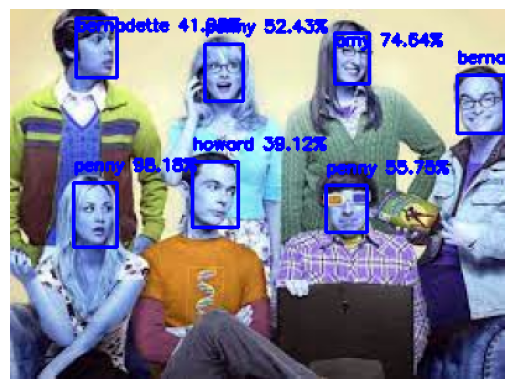

In [74]:
elenco = detect_and_class_faces('single_prediction/elenco2.jpg')

# Exibir a imagem usando plt.imshow
plt.imshow(elenco)
plt.axis('off')  # Desabilitar eixos
plt.show()       # Mostrar a imagem

Comentários finais:


Como a database fornecida foi baixa, os resultados da classificação não foram satisfatórios. Necessita de um aumento da base de dados para um re-treino com aproveitamento do modelo já salvo.